In [1]:
#!pip install Kaggle

In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2
from tensorflow.keras.losses import CategoricalCrossentropy

import kaggle


# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
!kaggle datasets download -d alinedobrovsky/plant-disease-classification-merged-dataset
!unzip plant-disease-classification-merged-dataset -d plant_disease_detection

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4adc46cc-60dd-48a7-8d4c-f6394577a14a___UF.GRC_YLCV_Lab 01543.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4ae10eb4-cd1f-490e-9ffe-61e348dad2b9___YLCV_GCREC 2785.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4ae45072-4db3-477d-9ace-9a08ce483d46___UF.GRC_YLCV_Lab 01407.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4ae66de5-2a7a-41bf-b0c3-7c00d2ce3b21___UF.GRC_YLCV_Lab 02136.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4af9c16d-2976-48f1-bb9a-bf7a3137488a___UF.GRC_YLCV_Lab 03352.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4b0733bc-70fa-46f7-9861-b135a461b67f___YLCV_GCREC 2397.JPG  
  inflating: plant_disease_detection/Tomato__yellow_leaf_curl_virus/4b2cf9f5-73eb-447d-ac4e-cfab8a228eb9___YLCV_GCREC 2158.JPG  
  inflating: plant_dis

In [5]:
path = '/content/plant_disease_detection'

In [6]:
lst = os.listdir(path)
lst.sort()
lst

['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Cherry__healthy',
 'Cherry__powdery_mildew',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Gauva__diseased',
 'Gauva__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Jamun__diseased',
 'Jamun__healthy',
 'Lemon__diseased',
 'Lemon__healthy',
 'Mango__diseased',
 'Mango__healthy',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Pomegranate__diseased',
 'Pome

### Prepare the training data

#### Used Class

In [7]:
usedClass = [
 'Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Corn__northern_leaf_blight',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast',
#  'Soybean__bacterial_blight',
#  'Soybean__caterpillar',
#  'Soybean__diabrotica_speciosa',
#  'Soybean__downy_mildew',
#  'Soybean__healthy',
#  'Soybean__mosaic_virus',
#  'Soybean__powdery_mildew',
#  'Soybean__rust',
#  'Soybean__southern_blight',
#  'Tea__algal_leaf',
#  'Tea__anthracnose',
#  'Tea__bird_eye_spot',
#  'Tea__brown_blight',
#  'Tea__healthy',
#  'Tea__red_leaf_spot',
# 'Tomato__bacterial_spot',
# 'Tomato__early_blight',
# 'Tomato__healthy',
# 'Tomato__late_blight',
# 'Tomato__leaf_mold',
# 'Tomato__mosaic_virus',
# 'Tomato__septoria_leaf_spot',
# 'Tomato__spider_mites_(two_spotted_spider_mite)',
# 'Tomato__target_spot',
# 'Tomato__yellow_leaf_curl_virus'
]

### Labeling

In [8]:
image_dir = Path(path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
image_df

,Filepath,Label
0,/content/plant_disease_detection/Gauva__health...,Gauva__healthy
1,/content/plant_disease_detection/Gauva__health...,Gauva__healthy
2,/content/plant_disease_detection/Gauva__health...,Gauva__healthy
3,/content/plant_disease_detection/Gauva__health...,Gauva__healthy
4,/content/plant_disease_detection/Gauva__health...,Gauva__healthy
...,...,...
79079,/content/plant_disease_detection/Sugarcane__he...,Sugarcane__healthy
79080,/content/plant_disease_detection/Peach__health...,Peach__healthy
79081,/content/plant_disease_detection/Peach__health...,Peach__healthy
79082,/content/plant_disease_detection/Peach__health...,Peach__healthy


In [10]:
labels_to_filter = usedClass
image_df = image_df[image_df['Label'].isin(labels_to_filter)]

In [11]:
len(image_df['Label'].unique())

31

In [12]:
image_df = image_df.reset_index()

### Subset data

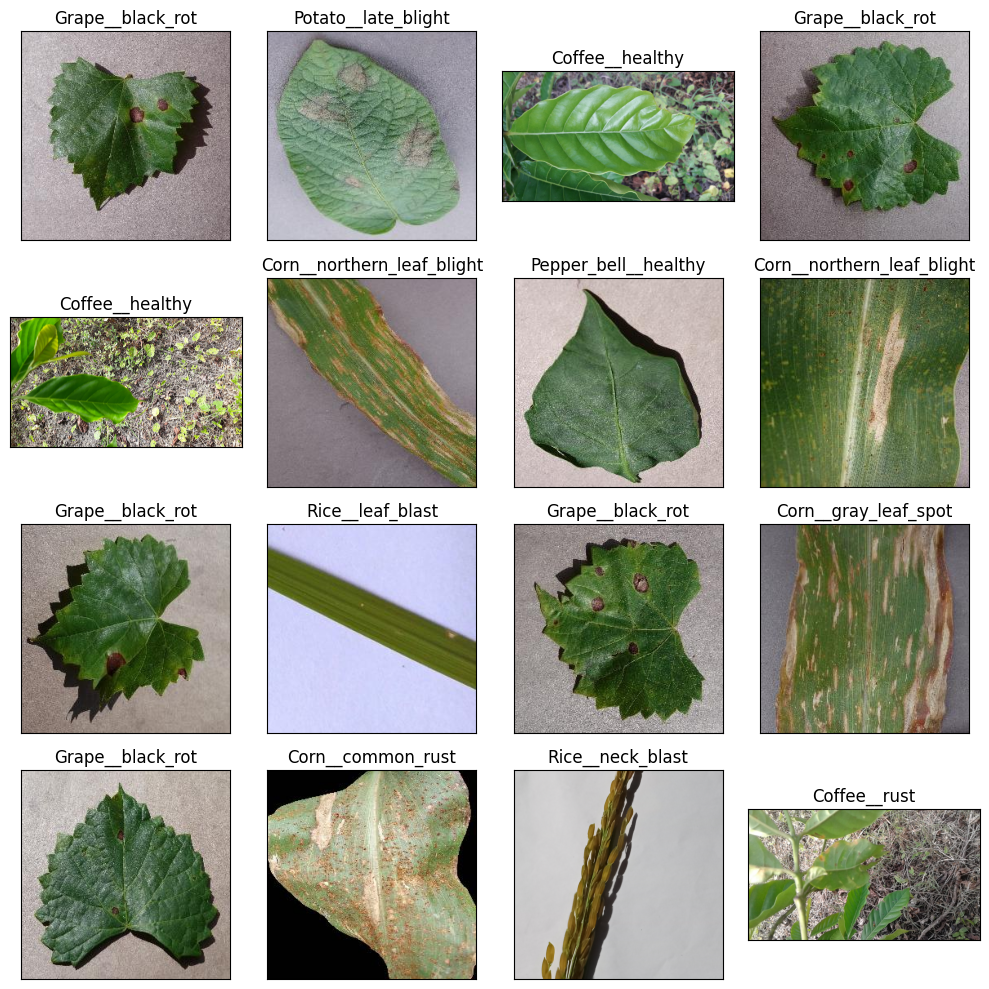

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### Data Processing

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [16]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 21428 validated image filenames belonging to 31 classes.
Found 5357 validated image filenames belonging to 31 classes.
Found 6697 validated image filenames belonging to 31 classes.


In [17]:
image_batch, label_batch = next(val_images)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 31))

### Data Training

#### Base Model

In [18]:
def create_pre_trained_model():
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)



  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False



  return pre_trained_model

In [19]:
pre_trained_model = create_pre_trained_model()

87910968/87910968 [==============================] - 3s 0us/step


In [20]:
# Create checkpoint callback
checkpoint_path = "disease_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [21]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [22]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """

  last_desired_layer = pre_trained_model.get_layer('mixed9')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [23]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 5, 5, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 2048), dtype=tf.float32, name=None), name='mixed9/concat:0', description="created by layer 'mixed9'")


In [29]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  x = layers.GlobalAveragePooling2D()(last_output)
  x =tf.keras.layers.Dense(units=512, activation='relu')(x)
  x =tf.keras.layers.Dropout(0.2)(x)
  x =tf.keras.layers.Dense(units=256, activation='relu')(x)
  x =tf.keras.layers.Dropout(0.2)(x)
  x =tf.keras.layers.Dense(units=128, activation='relu')(x)
  x =tf.keras.layers.Dense(units=31, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = Adam(),
                loss = CategoricalCrossentropy(),
                metrics = ['accuracy'])


  return model

In [30]:
model = create_final_model(pre_trained_model, last_output)
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 16,940,031 total parameters in this model.
There are 1,217,311 trainable parameters in this model.


In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [32]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 8


In [33]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
670/670 [==============================] - 549s 809ms/step - loss: 0.6693 - accuracy: 0.7805 - val_loss: 0.3651 - val_accuracy: 0.8654
Epoch 2/10
670/670 [==============================] - 523s 781ms/step - loss: 0.3750 - accuracy: 0.8656 - val_loss: 0.3223 - val_accuracy: 0.8818
Epoch 3/10
670/670 [==============================] - 509s 759ms/step - loss: 0.3215 - accuracy: 0.8842 - val_loss: 0.2763 - val_accuracy: 0.9001
Epoch 4/10
670/670 [==============================] - 509s 760ms/step - loss: 0.2992 - accuracy: 0.8926 - val_loss: 0.3104 - val_accuracy: 0.8901
Epoch 5/10
670/670 [==============================] - 487s 727ms/step - loss: 0.2852 - accuracy: 0.8957 - val_loss: 0.2491 - val_accuracy: 0.9065
Epoch 6/10
670/670 [==============================] - 488s 728ms/step - loss: 0.2687 - accuracy: 0.9042 - val_loss: 0.2545 - val_accuracy: 0.9063
Epoch 7/10
670/670 [==============================] - 485s 724ms/step - loss: 0.2504 - accuracy: 0.9083 - val_loss: 0.2431 -

In [34]:
model.save('/content/model.h5')
model.save("plant_disease_detection.h5")

In [35]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
670/670 [==============================] - 465s 694ms/step - loss: 0.2395 - accuracy: 0.9128 - val_loss: 0.2207 - val_accuracy: 0.9207
Epoch 2/10
670/670 [==============================] - 468s 699ms/step - loss: 0.2286 - accuracy: 0.9164 - val_loss: 0.2320 - val_accuracy: 0.9149
Epoch 3/10
670/670 [==============================] - 469s 700ms/step - loss: 0.2256 - accuracy: 0.9170 - val_loss: 0.2334 - val_accuracy: 0.9156
Epoch 4/10
670/670 [==============================] - 471s 704ms/step - loss: 0.2186 - accuracy: 0.9195 - val_loss: 0.2298 - val_accuracy: 0.9205
Epoch 5/10
670/670 [==============================] - 474s 707ms/step - loss: 0.2149 - accuracy: 0.9199 - val_loss: 0.2446 - val_accuracy: 0.9136
Epoch 6/10
670/670 [==============================] - 478s 713ms/step - loss: 0.2087 - accuracy: 0.9233 - val_loss: 0.2304 - val_accuracy: 0.9192


In [36]:
model.save('/content/model.h5')
model.save("plant_disease_detection.h5")

In [37]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
670/670 [==============================] - 477s 712ms/step - loss: 0.2302 - accuracy: 0.9167 - val_loss: 0.2359 - val_accuracy: 0.9177
Epoch 2/10
670/670 [==============================] - 485s 723ms/step - loss: 0.2263 - accuracy: 0.9196 - val_loss: 0.2176 - val_accuracy: 0.9190
Epoch 3/10
670/670 [==============================] - 478s 713ms/step - loss: 0.2244 - accuracy: 0.9195 - val_loss: 0.2473 - val_accuracy: 0.9156
Epoch 4/10
670/670 [==============================] - 473s 705ms/step - loss: 0.2246 - accuracy: 0.9184 - val_loss: 0.2329 - val_accuracy: 0.9145
Epoch 5/10
670/670 [==============================] - 471s 703ms/step - loss: 0.2115 - accuracy: 0.9245 - val_loss: 0.2409 - val_accuracy: 0.9190
Epoch 6/10
670/670 [==============================] - 473s 707ms/step - loss: 0.2085 - accuracy: 0.9245 - val_loss: 0.2392 - val_accuracy: 0.9186
Epoch 7/10
670/670 [==============================] - 467s 697ms/step - loss: 0.2062 - accuracy: 0.9248 - val_loss: 0.2302 -

In [38]:
model.save('/content/model.h5')
model.save("plant_disease_detection.h5")

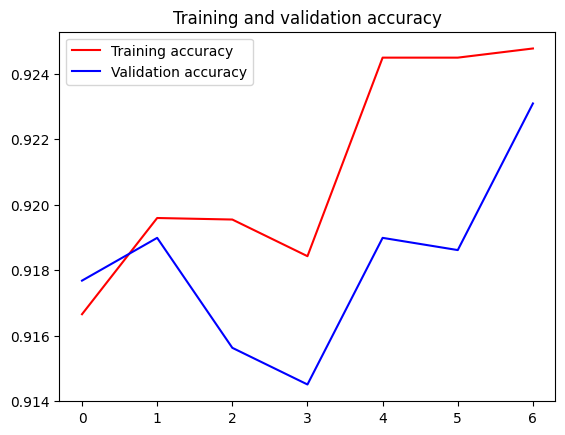

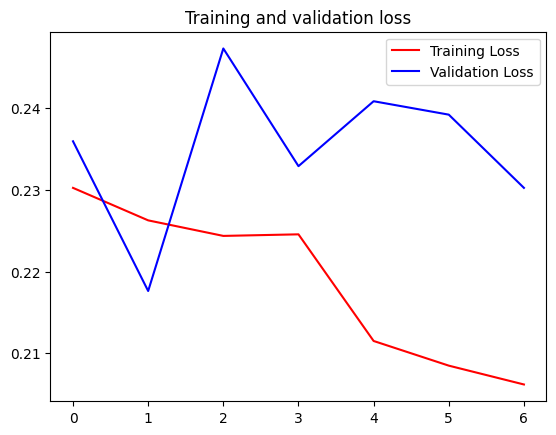

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [40]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.24148
Test Accuracy: 91.44%


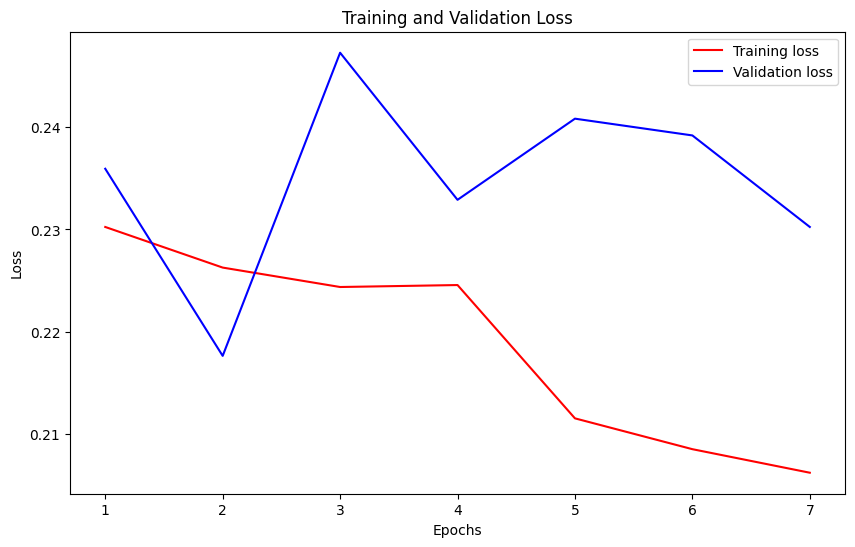

In [41]:
def plot_loss_curves(history):
    # Extract training and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Generate a list of epoch numbers
    epochs = range(1, len(loss) + 1)

    # Create a new figure with a specified size
    plt.figure(figsize=(10, 6))

    # Plot training loss in red and label it as 'Training loss'
    plt.plot(epochs, loss, 'r', label='Training loss')

    # Plot validation loss in blue and label it as 'Validation loss'
    plt.plot(epochs, val_loss, 'b', label='Validation loss')

    # Set the title of the plot
    plt.title('Training and Validation Loss')

    # Label the x-axis as 'Epochs'
    plt.xlabel('Epochs')

    # Label the y-axis as 'Loss'
    plt.ylabel('Loss')

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

# Call the function to plot the loss curves from the training history
plot_loss_curves(history)

### Fine tune the base model

In [42]:
print("Number of layers in the base model: ", len(pre_trained_model.layers))

Number of layers in the base model:  311


In [43]:
pre_trained_model.trainable = True
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [46]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 148
